Name: Prem Patel
Course: Data Acquisition/Proc II
Assignment: Final Project
Submission date: 12/17/2020

Problem desription:

Task: 
In this competition, you'll write an algorithm to classify whether images contain either a dog or a cat.  This is easy for humans, dogs, and cats. Your computer will find it a bit more difficult.
You can exploit all the skill sets you have learned in this class to practice your model experience. 

Data Description:
The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat).

Kaggle URL for training and testing data download:
https://www.kaggle.com/c/dogs-vs-cats (Links to an external site.)

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [2]:
# Standardization and defining constants
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [12]:
# Preparing Data
filenames=os.listdir("G:/My Drive/Semester 3/EE 628/Final Project/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [15]:
# Modeling building

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau 

# To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased
earlystop = EarlyStopping(patience=10)

# To reduce the learning rate when then accuracy not increase for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [21]:
# Preparing Data

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [22]:
# Training Generator

train_datagen = ImageDataGenerator(rotation_range=15, rescale=1./255, shear_range=0.1, zoom_range=0.2, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "G:/My Drive/Semester 3/EE 628/Final Project/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [24]:
# Validation Generator

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "G:/My Drive/Semester 3/EE 628/Final Project/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [25]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "G:/My Drive/Semester 3/EE 628/Final Project/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


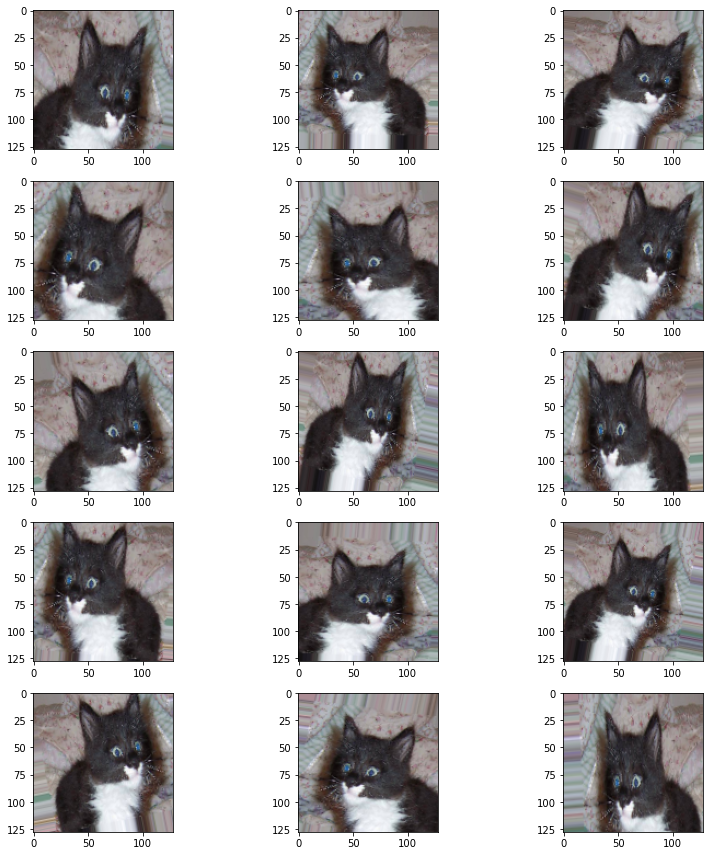

In [26]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [28]:
# Fitting the model

epochs=3 if FAST_RUN else 10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1333/1333 [==============================] - 801s 601ms/step - loss: 0.7020 - accuracy: 0.6434 - val_loss: 0.6722 - val_accuracy: 0.6707
Epoch 2/10
1333/1333 [==============================] - 804s 603ms/step - loss: 0.5369 - accuracy: 0.7354 - val_loss: 1.4301 - val_accuracy: 0.5245
Epoch 3/10
1333/1333 [==============================] - 824s 618ms/step - loss: 0.4818 - accuracy: 0.7739 - val_loss: 0.4387 - val_accuracy: 0.7996
Epoch 4/10
1333/1333 [==============================] - 815s 611ms/step - loss: 0.4529 - accuracy: 0.7924 - val_loss: 0.4470 - val_accuracy: 0.7882
Epoch 5/10
1333/1333 [==============================] - 817s 613ms/step - loss: 0.4288 - accuracy: 0.8046 - val_loss: 0.3914 - val_accuracy: 0.8338
Epoch 6/10
1333/1333 [==============================] - 821s 616ms/step - loss: 0.4157 - accuracy: 0.8113 - val_loss: 0.6313 - val_accuracy: 0.6585
Epoch 7/10
1333/1333 [==============================] - 821s 616ms/step - loss: 0.3942 - accuracy: 0.8252 - val_

In [29]:
model.save_weights("model.h5")

In [31]:
#test data

test_filenames = os.listdir("G:/My Drive/Semester 3/EE 628/Final Project/test1/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [32]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "G:/My Drive/Semester 3/EE 628/Final Project/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [33]:
# Prediction

predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

Instructions for updating:
Please use Model.predict, which supports generators.


In [34]:
test_df['category'] = np.argmax(predict, axis=-1)


In [35]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [36]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

<AxesSubplot:>

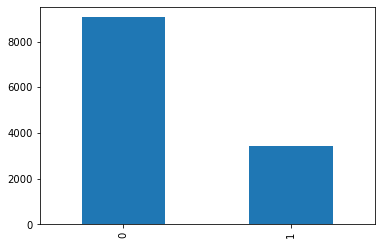

In [37]:
test_df['category'].value_counts().plot.bar()

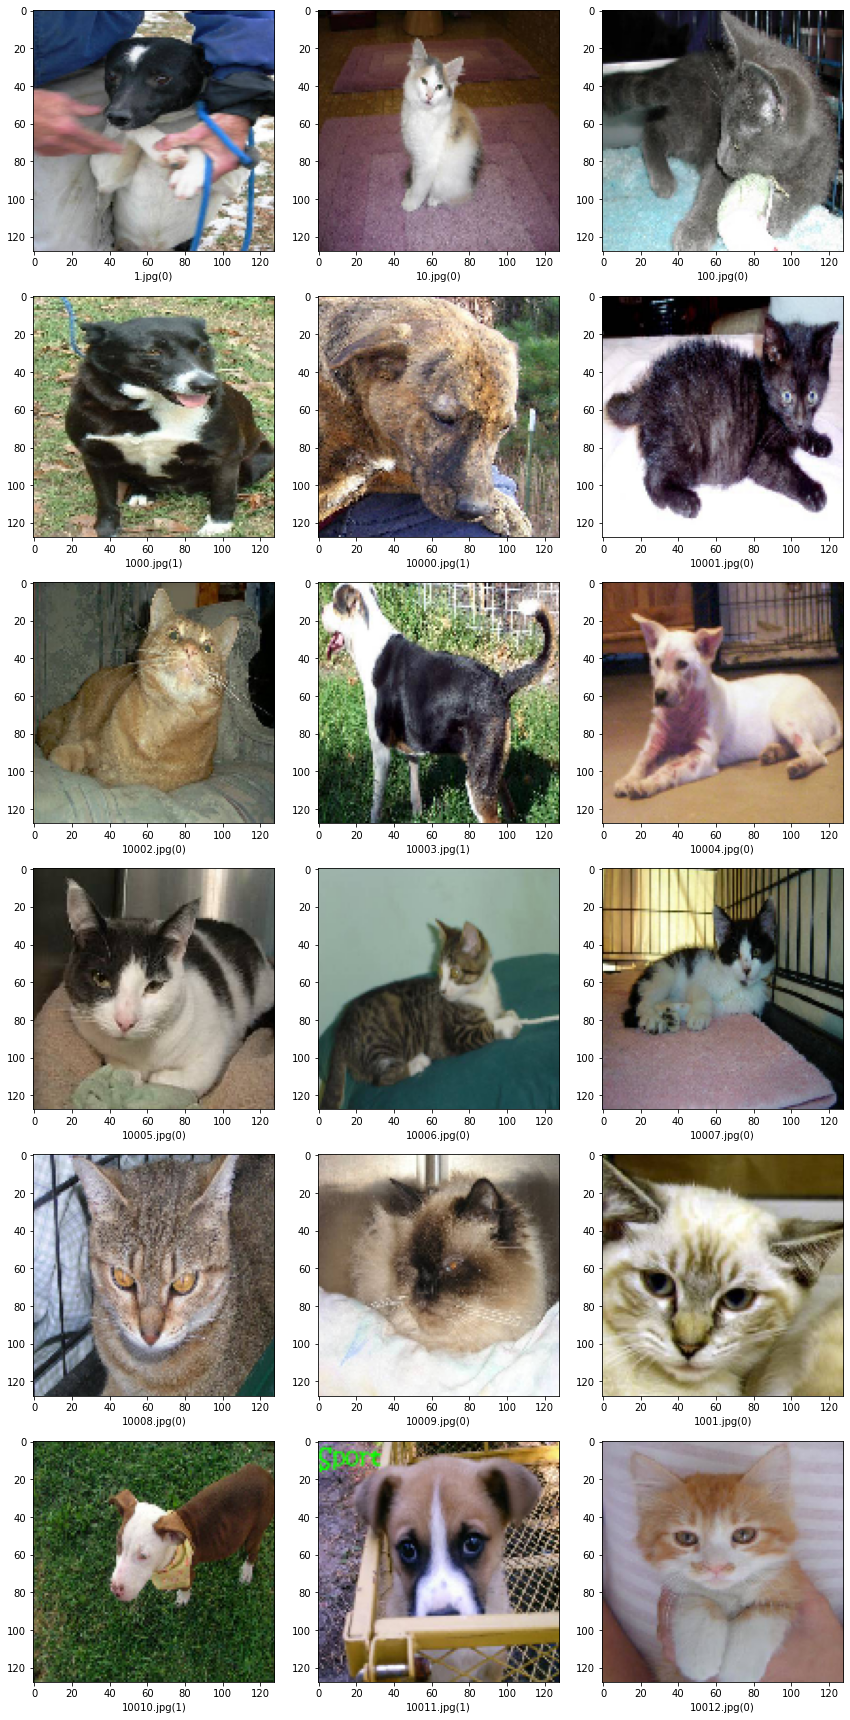

In [38]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("G:/My Drive/Semester 3/EE 628/Final Project/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [39]:
# output

output_df = test_df.copy()
output_df['id'] = output_df['filename'].str.split('.').str[0]
output_df['label'] = output_df['category']
output_df.drop(['filename', 'category'], axis=1, inplace=True)
output_df.to_csv('output.csv', index=False)